# Applying UMAP to RFFNet

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import torch
from numpy.random import SeedSequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pyselect.datasets import  make_gregorova_se1
from pyselect.model import RFFNet, RFFLayer

## Random

In [2]:
seed_sequence = SeedSequence(entropy=0)

In [3]:
seed = seed_sequence.generate_state(1)[0]

## Data

In [4]:
n_samples = 5*10**3
train_size = 4*10**3
n_features = 18

In [5]:
X, y = make_gregorova_se1(n_samples=n_samples, random_state=seed)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size,
                                                    random_state=seed)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [8]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)

## Model

In [9]:
n_epochs = 100
batch_size = 32

In [10]:
def prox_2_squared(x, alpha):
    "Proximal operator for l2 norm squared."
    return x / (1 + 2 * alpha)


In [11]:
def train(n_random_features, alpha=1e-2, lr=1e-2, batch_size=500, min_delta_fraction=0.8, n_iter_no_change=10):
        
    torch.manual_seed(seed)
    model = RFFNet(dims=[n_features, n_random_features, 1])
    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
    optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)

    no_improvement_count = 0
    best_val_loss = torch.Tensor([float("Inf")])
    
    criterion = torch.nn.MSELoss()
    
    adam_history_train = []
    adam_history_val = []

    model_array = np.zeros((n_epochs, max_rf + n_features))
    
    for epoch in range(n_epochs):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])
            
            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()
            
            with torch.no_grad():
                curr_lr = optim_linear.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, alpha * curr_lr
                )

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()
                
        with torch.no_grad():
            adam_history_train.append(loss.item())
        
            val_loss = criterion(model(X_val), y_val)
            adam_history_val.append(val_loss.item())
            model_array[epoch, :n_random_features] = model.linear.weight.numpy().flatten()
            model_array[epoch, -n_features:] = np.abs(model.rff.precisions.numpy())
            
        if val_loss < min_delta_fraction*best_val_loss:
            best_model_state_dict = model.state_dict()
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count == n_iter_no_change:  
            break
          
    model.load_state_dict(best_model_state_dict)
    
    return adam_history_train, adam_history_val, model_array[:epoch+1], model.state_dict()

In [12]:
max_rf = int(np.sqrt(train_size)*np.log(train_size))

In [13]:
HYPERPARAMS = {
    "n_random_features": [max_rf],
    "lr": np.logspace(-3, -1, 4),
    "batch_size":[10, 50, 100, 200],
    "min_delta_fraction":[0.8, 0.9, 0.95],
    "n_iter_no_change":[5, 10],
    "alpha":np.logspace(-7, 1, 7)
}
hyperparams = [dict(x)
               for x in itertools.product(*[[(k, v) for v in vs]
                                            for k, vs in HYPERPARAMS.items()])]

## Creating vector representations of models 

In [14]:
import matplotlib as mpl
from tqdm import tqdm
import umap

In [15]:
def generate_rep(hyperparams):
    train_history_list = []
    val_history_list = []
    param_list = []
    for i, params in tqdm(enumerate(hyperparams)):
        train_hist, val_hist, params, _ = train(**params)
        train_history_list.extend(train_hist)
        val_history_list.extend(val_hist)
        param_list.append(params)
    
    return train_history_list, val_history_list, param_list

In [16]:
train_history_list, val_history_list, param_list = generate_rep(hyperparams)

672it [14:06,  1.26s/it]


In [17]:
param_array = np.concatenate(param_list)

In [18]:
reducer = umap.UMAP(densmap=True, random_state=0, n_jobs=-1, n_neighbors=30)

In [19]:
reducer.fit(param_array)

UMAP(densmap=True, n_neighbors=30, random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [20]:
embedding = reducer.embedding_

In [21]:
xs, ys = embedding[:, 0], embedding[:, 1]

In [22]:
CMIN = np.min([train_history_list, val_history_list])
CMAX = np.max([train_history_list, val_history_list])

In [23]:
mpl.rcParams['axes.spines.left']   = False
mpl.rcParams['axes.spines.right']  = False
mpl.rcParams['axes.spines.top']    = False
mpl.rcParams['axes.spines.bottom'] = False

In [24]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection

In [25]:
import seaborn as sns

In [26]:
COLORMAP = sns.color_palette("Spectral_r", as_cmap=True)
#COLORMAP = plt.cm.plasma_r

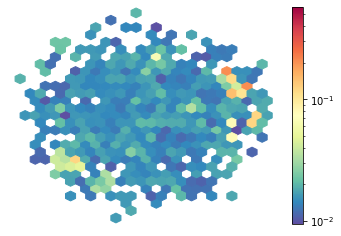

In [27]:
fig, ax= plt.subplots(1,1)
hexbins = ax.hexbin(xs, ys, C=train_history_list, gridsize=25, cmap=COLORMAP)
hexbins.set_clim(CMIN, CMAX)
ax.set_xlim(xs.min()-2, xs.max()+2)
ax.set_ylim(ys.min()-2, ys.max()+2)
ax.set_xticks([])
ax.set_yticks([])
colorbar = fig.colorbar(ScalarMappable(norm=mpl.colors.LogNorm(CMIN, CMAX), cmap=COLORMAP), ax=ax)
#colorbar = fig.colorbar(ScalarMappable(norm=mpl.colors.Normalize(CMIN, CMAX), cmap=COLORMAP), ax=ax)
plt.show()

## Getting each model trajectory

In [28]:
import scipy

In [29]:
durations = np.cumsum([param_list[i].shape[0] for i in range(len(param_list))])

In [30]:
final_losses = np.array([val_history_list[i-1] for i in durations])

In [31]:
def select_model(low=True):
    selection = -1
    if low:
        max_loss = np.quantile(final_losses, 0.05)
        selected_loss = final_losses[final_losses < max_loss][selection]
    else:
        max_loss = np.quantile(final_losses, 0.95)
        selected_loss = final_losses[final_losses > max_loss][selection]

    selection, = np.where(final_losses == selected_loss)
    selection = selection[0]
    return selection

In [110]:
from matplotlib.ticker import LogFormatter

In [144]:
def plot_one(low=True, rate=1, savefig=None):
    selection = select_model(low)
    if selection == 0:
        js = list(range(0, durations[selection]))
    else:
        js = list(range(durations[selection-1], durations[selection]))
    unique_pts = np.unique(np.array([xs[js], ys[js]]).T, axis=0)    
    
    xjs, yjs = unique_pts[:, 0], unique_pts[:, 1]
    
    tck, u = scipy.interpolate.splprep([xjs[::rate], yjs[::rate]], s=5)
    
    spline_domain = np.linspace(0, 1, 500)
    spline_x, spline_y = scipy.interpolate.splev(spline_domain, tck)
    spline_points = np.array([spline_x, spline_y]).T.reshape(-1, 1, 2)
    spline_segments = np.concatenate([spline_points[:-1], spline_points[1:]], axis=1)
    
    fig, axs = plt.subplots(2, 1, figsize=(TEXTWIDTH, TEXTWIDTH))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    hexbins = axs[0].hexbin(xs, ys, C=train_history_list, gridsize=25, cmap=COLORMAP)
    hexbins.set_clim(CMIN, CMAX)
    axs[0].set_xlim(xs.min()-3, xs.max()+3)
    axs[0].set_ylim(ys.min()-3, ys.max()+3)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_ylabel("Train")

    lc = LineCollection(spline_segments, linewidths=0.75*(1-spline_domain)+0.9, color='k')
    lc.set_capstyle('round')
    axs[0].add_collection(lc)
    axs[0].scatter(xjs[::rate], yjs[::rate], marker='x', lw=0.1, s=20, c='k')
    
    hexbins = axs[1].hexbin(xs, ys, C=val_history_list,  gridsize=25, cmap=COLORMAP)
    hexbins.set_clim(CMIN, CMAX)
    axs[1].set_xlim(xs.min()-3, xs.max()+3)
    axs[1].set_ylim(ys.min()-3, ys.max()+3)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_ylabel("Test")

    lc = LineCollection(spline_segments, linewidths=0.75*(1-spline_domain)+0.9, color='k')
    lc.set_capstyle('round')
    axs[1].add_collection(lc)
    axs[1].scatter(xjs[::rate], yjs[::rate], marker='x', lw=0.1, s=20, c='k')
    
    colorbar = fig.colorbar(ScalarMappable(norm=mpl.colors.LogNorm(CMIN, CMAX), cmap=COLORMAP), ax=axs[:2])
    colorbar.set_label("MSE", rotation=90)
    
    if savefig:
        plt.savefig(savefig, bbox_inches="tight")
     
    plt.show()
    
    return selection

In [145]:
TEXTWIDTH = 6.25063
FONTSIZE = 9

In [146]:
import matplotlib

In [147]:
def setup():
    matplotlib.rcParams.update({"font.size": FONTSIZE})  # controls default text sizes
    matplotlib.rcParams.update({"axes.titlesize": FONTSIZE})  # fontsize of the axes title
    matplotlib.rcParams.update({"axes.labelsize": FONTSIZE})  # fontsize of the x and y labels
    matplotlib.rcParams.update({"axes.formatter.use_mathtext": True})  # use scientific notation for axes with pretty formatting
    matplotlib.rcParams.update({"axes.formatter.useoffset": True}) #
    matplotlib.rcParams.update({"axes.formatter.limits": [0, 0]})  
    matplotlib.rcParams.update({"xtick.labelsize": FONTSIZE})  # fontsize of the tick labels
    matplotlib.rcParams.update({"ytick.labelsize": FONTSIZE})  # fontsize of the tick labels
    matplotlib.rcParams.update({"legend.fontsize": FONTSIZE})  # legend fontsize
    matplotlib.rcParams.update({"figure.titlesize": FONTSIZE})  # fontsize of the figure title
    mpl.rcParams['axes.spines.left']   = False
    mpl.rcParams['axes.spines.right']  = False
    mpl.rcParams['axes.spines.top']    = False
    mpl.rcParams['axes.spines.bottom'] = False

In [148]:
setup()

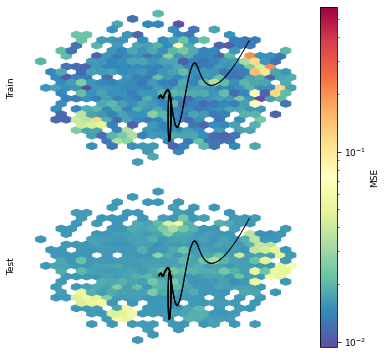

In [149]:
selection_good = plot_one(low=True,rate=1,savefig="../figures/validation/trajectory-gregorova-good.pdf")

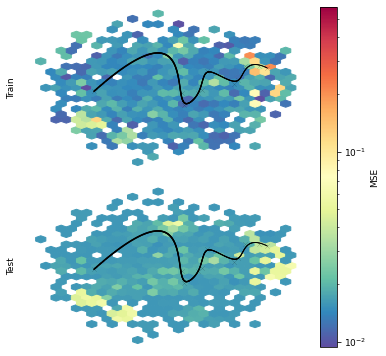

In [150]:
selection_bad = plot_one(low=False,rate=1,savefig="../figures/validation/trajectory-gregorova-bad.pdf")

# Identification

In [169]:
from sklearn.preprocessing import MinMaxScaler

In [170]:
scaler = MinMaxScaler()

In [171]:
CMAP = plt.cm.plasma
CMAP_R = plt.cm.plasma_r
COLORS = [CMAP(i / 4.0) for i in range(5)]

In [172]:
COLOR_0 = COLORS[0]
COLOR_1 = COLORS[1]
COLOR_2 = COLORS[2]
COLOR_3 = COLORS[3]

In [173]:
mpl.rcParams['axes.spines.left']   = True
mpl.rcParams['axes.spines.right']  = True
mpl.rcParams['axes.spines.top']    = True
mpl.rcParams['axes.spines.bottom'] = True

In [174]:
TEXTWIDTH = 3.25063
FONTSIZE = 6

In [175]:
precisions = scaler.fit_transform(np.abs(param_list[selection_good][-1][-18:]).reshape(-1,1)).ravel()

In [176]:
x = np.arange(1, 19, 1)
x_labels = [i if i in (1,3,7,8,9) else "" for i in range(1, 19)]

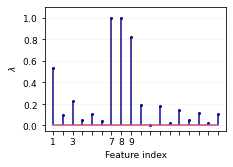

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(TEXTWIDTH, 0.7*TEXTWIDTH), sharex=True)
conf = ax.stem(x, precisions)
ax.set_ylabel("$\lambda$")
plt.setp(conf[0], ms=2, color=COLOR_0)
plt.setp(conf[1], color=COLOR_0)
plt.setp(conf[2], color=COLOR_2)
plt.xticks(x, x_labels)
ax.grid(alpha=0.3, linestyle='dashed', linewidth=0.5)
ax.xaxis.grid()
ax.set_ylim(-0.05, 1.1)
ax.set_xlabel("Feature index")
plt.savefig("../figures/validation/identification-gregorova-good.pdf", bbox_inches="tight")
plt.show()

In [178]:
precisions = scaler.fit_transform(np.abs(param_list[selection_bad][-1][-18:]).reshape(-1,1)).ravel()

In [179]:
x = np.arange(1, 19, 1)
x_labels = [i if i in (1,3,7,8,9) else "" for i in range(1, 19)]

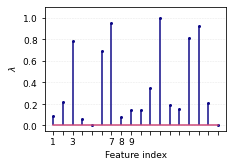

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(TEXTWIDTH, 0.7*TEXTWIDTH), sharex=True)
conf = ax.stem(x, precisions)
ax.set_ylabel("$\lambda$")
plt.setp(conf[0], ms=2, color=COLOR_0)
plt.setp(conf[1], color=COLOR_0)
plt.setp(conf[2], color=COLOR_2)
plt.xticks(x, x_labels)
ax.grid(alpha=0.3, linestyle='dashed', linewidth=0.5)
ax.xaxis.grid()
ax.set_ylim(-0.05, 1.1)
ax.set_xlabel("Feature index")
plt.savefig("../figures/validation/identification-gregorova-bad.pdf", bbox_inches="tight")
plt.show()